<a href="https://colab.research.google.com/github/sgcortes/25ForageYieldNWSpain/blob/main/V7_CP_RFR_LGBM_XGB_OPTUNA_SHAP_PERMU_kgDM_RAD_Dia_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Regression Models Comparation (LightGBM, XGBoost. Adaboost, Random Forest Regressor. Hyperparameter Tuning with Optuna on best models)

Training and evaluation of 4 basic regression models and additional Hyperparameter optimization with Optuna for LightGBM,XGBoost and RFR.
The last one does not improve metrics with respect to the basic model.

 + LightGBM and XGBoost use categorical variables natively (no codification),
 + Random Forest Regressor and AdaBoost use onehot encoder.
 + No normalization on variable values (e.g. no standarization. This is not needed with ensemble models based on decision trees)
 + Radiation diary mean values (no acumulated radiation values during all the growing season).


In [1]:
!pip show lightgbm | grep 'Version: 4.6.0' || pip install lightgbm==4.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [2]:
# 🔧 Instalación de librerías necesarias
try:
    import optuna
    import lightgbm
    import xgboost
    import shap
    import openpyxl
    import joblib
except ImportError:
    !pip install -q optuna lightgbm xgboost shap scikit-learn openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.1 MB/s eta 0:00:00


In [3]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [4]:
# 📂 Cargar datos
file_path = '/content/260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx'
df = pd.read_excel(file_path)

In [5]:
# 🎯 Selección de variable objetivo
print("Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']")
objective_var = input("Introduce la variable objetivo para la regresión: ")
assert objective_var in ['kgDM/ha', 'kgCP/ha', 'UFL/ha'], "Variable no válida."

Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']
Introduce la variable objetivo para la regresión: kgCP/ha


In [6]:
# Variables
categorical_features = ['Site', 'Cultivar']


y = df[objective_var]
X = df.drop(columns=['kgDM/ha', 'kgCP/ha', 'UFL/ha'])
# Convertir las columnas categóricas a 'category'
for col in categorical_features:
    X[col] = X[col].astype('category')

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##
print(X.columns,"\n")
#print(X.head)

Index(['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)',
       'Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)',
       'GrowingSeason(day)'],
      dtype='object') 



# 🔵 Basic Model  Training (no hyperparameter optimization). LightGBM, XGBoost, Adaboost and Random Forest Regressors.  

In [7]:
# LightGBM básico
lgb_basic = lgb.LGBMRegressor(categorical_feature=categorical_features)
lgb_basic.fit(X_train, y_train)
y_pred_lgb_basic = lgb_basic.predict(X_test)

# XGBoost básico
xgb_basic = xgb.XGBRegressor(enable_categorical=True, tree_method='hist')
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)

# One-hot encoding para AdaBoost y Random Forest
X_encoded = pd.get_dummies(X, columns=categorical_features)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🔸 AdaBoost Regressor (modelo base: DecisionTree)
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train_enc, y_train_enc)
y_pred_adaboost = adaboost_model.predict(X_test_enc)

# 🔸 Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_enc, y_train_enc)
y_pred_rf = rf_model.predict(X_test_enc)

[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 1104.761648


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


# 📈 Basic Models Evaluation

In [8]:
def evaluate(y_true, y_pred, name="Modelo"):
    print(f"\n{name}")
    print("R2:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

evaluate(y_test, y_pred_lgb_basic, name="LightGBM Basic")
evaluate(y_test, y_pred_xgb_basic, name="XGBoost Basic")
evaluate(y_test, y_pred_adaboost, name="AdaBoost Basic")
evaluate(y_test, y_pred_rf, name="Random Forest Basic")


LightGBM Basic
R2: 0.8511736973681335
RMSE: 91.73168798817501
MAE: 66.78905398239343
MAPE: 6.956258101460598

XGBoost Basic
R2: 0.8281225034971249
RMSE: 98.58005329241811
MAE: 71.9091154953529
MAPE: 7.388331100596887

AdaBoost Basic
R2: 0.6940982683211769
RMSE: 131.51355171859294
MAE: 103.49091144797389
MAPE: 10.366018404702174

Random Forest Basic
R2: 0.8290591120085196
RMSE: 98.31109124974414
MAE: 72.63793103448276
MAPE: 7.565432468696096


### Variable importance for RMS global reduction

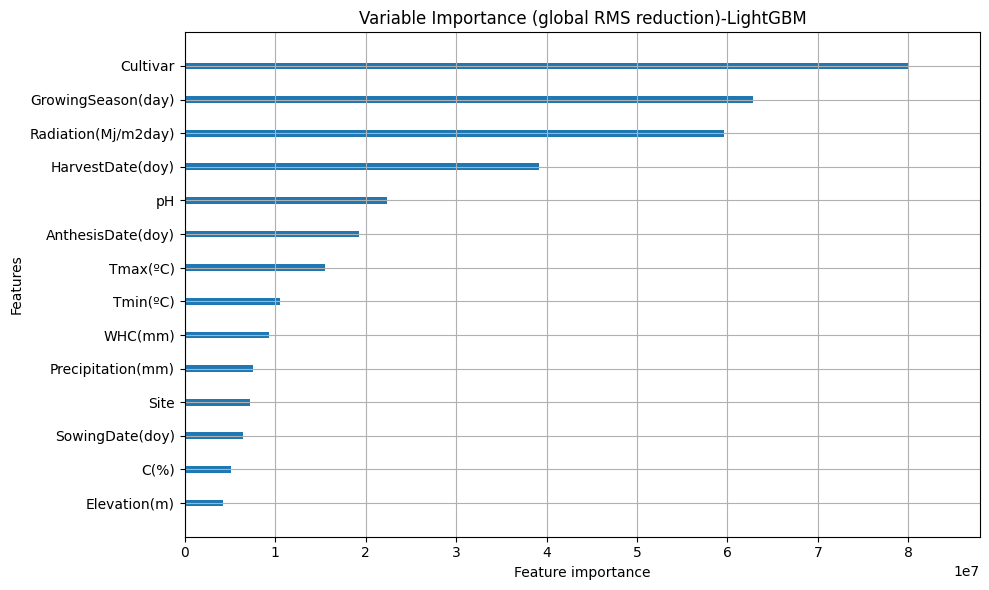

In [9]:
# Asumiendo que lgb_model ya está entrenado
booster = lgb_basic.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title("Variable Importance (global RMS reduction)-LightGBM")
plt.tight_layout()
plt.show()

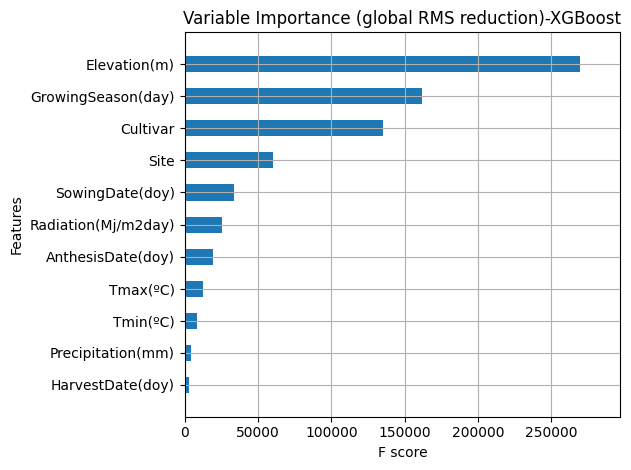

In [10]:
xgb.plot_importance(
    xgb_basic,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost')
plt.tight_layout()
plt.show()

### Variable importance for RMS reduction with Adaboost and Random Forest Regressor

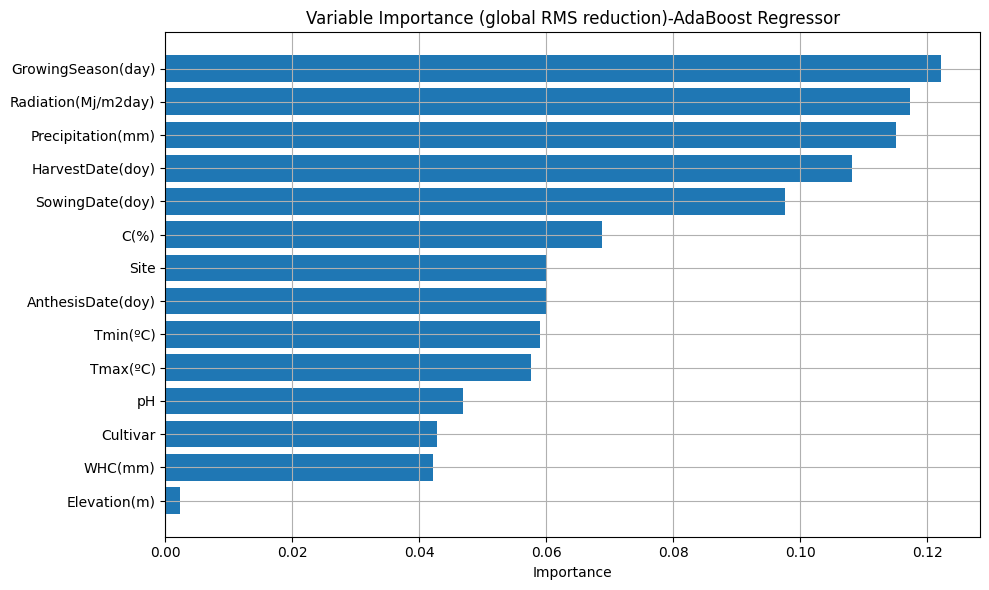

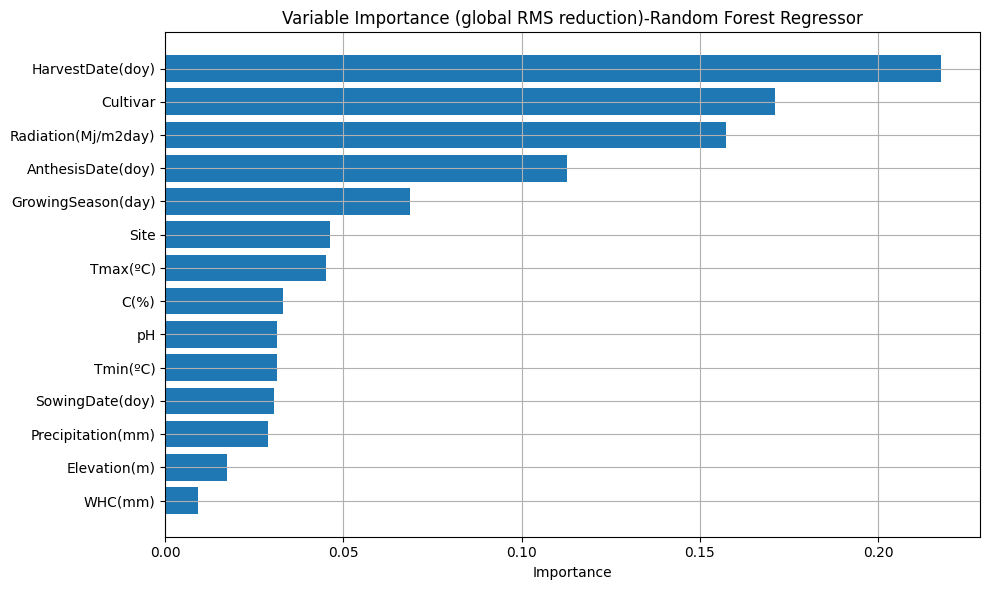

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Obtener nombres de las características
feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f'Feature_{i}' for i in range(X_train_enc.shape[1])]

def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Agrupar variables por prefijo (antes del "_") o quedarse con el nombre si no hay "_"
    def agrupar_nombre(col):
        if '_' in col:
            return col.split('_')[0]  # e.g., Cultivar_200 → Cultivar
        else:
            return col

    importance_df['grupo'] = importance_df['feature'].apply(agrupar_nombre)
    grouped = importance_df.groupby('grupo', as_index=False)['importance'].sum()

    # Orden descendente por importancia
    grouped_sorted = grouped.sort_values(by='importance', ascending=True)

    return grouped_sorted

def plot_feature_importances_grouped(importances, model_name):
    grouped_df = agrupar_importancias(importances, feature_names)

    plt.figure(figsize=(10, 6))
    plt.barh(grouped_df['grupo'], grouped_df['importance'])
    plt.xlabel('Importance')
    plt.title(f'Variable Importance (global RMS reduction)-{model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔹 AdaBoost
plot_feature_importances_grouped(adaboost_model.feature_importances_, 'AdaBoost Regressor')

# 🔸 Random Forest
plot_feature_importances_grouped(rf_model.feature_importances_, 'Random Forest Regressor')


# 🧪 Hyperparameter Optimization with Optuna

In [12]:
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train_enc, y_train_enc, cv=5, scoring='r2', n_jobs=-1).mean()
    return score


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)


[I 2025-05-18 12:18:44,591] A new study created in memory with name: no-name-3ec23507-fc22-4306-a925-025758dba3f7


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-18 12:18:45,346] Trial 0 finished with value: 94.32725291103188 and parameters: {'learning_rate': 0.20067596691276626, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.6320445232647635, 'colsample_bytree': 0.8556350493289413}. Best is trial 0 with value: 94.32725291103188.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 1104.350754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:46,303] Trial 1 finished with value: 115.70291291330086 and parameters: {'learning_rate': 0.028881867332506493, 'num_leaves': 157, 'max_depth': 15, 'min_child_samples': 70, 'subsample': 0.7132813024398066, 'colsample_bytree': 0.996543998285478}. Best is trial 0 with value: 94.32725291103188.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:48,438] Trial 2 finished with value: 94.7158519471937 and parameters: {'learning_rate': 0.09193784081817714, 'num_leaves': 128, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.5418552825257672, 'colsample_bytree': 0.804122286657325}. Best is trial 0 with value: 94.32725291103188.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:18:48,859] Trial 3 finished with value: 99.37027133871372 and parameters: {'learning_rate': 0.2168131998099411, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 38, 'subsample': 0.9032535495013505, 'colsample_bytree': 0.5356325573618219}. Best is trial 0 with value: 94.32725291103188.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:50,132] Trial 4 finished with value: 95.56610704889276 and parameters: {'learning_rate': 0.04396149829005875, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9027199168704044, 'colsample_bytree': 0.6788918915038669}. Best is trial 0 with value: 94.32725291103188.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:50,745] Trial 5 finished with value: 110.90165209796116 and parameters: {'learning_rate': 0.04501079601162571, 'num_leaves': 158, 'max_depth': 5, 'min_child_samples': 86, 'subsample': 0.7452550244627059, 'colsample_bytree': 0.7671350041901801}. Best is trial 0 with value: 94.32725291103188.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:51,525] Trial 6 finished with value: 92.98676008735018 and parameters: {'learning_rate': 0.14248857160227907, 'num_leaves': 100, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.8427914907506919, 'colsample_bytree': 0.8523235640955542}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 1104.350754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-18 12:18:52,134] Trial 7 finished with value: 97.01076529597267 and parameters: {'learning_rate': 0.05802596714848706, 'num_leaves': 142, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8915541350625431, 'colsample_bytree': 0.5356439205200423}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:18:52,440] Trial 8 finished with value: 99.72835140987529 and parameters: {'learning_rate': 0.2646143183860831, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 74, 'subsample': 0.7309452335492972, 'colsample_bytree': 0.6850430875549018}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1109.769417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:53,155] Trial 9 finished with value: 113.39363525195031 and parameters: {'learning_rate': 0.015734414825891566, 'num_leaves': 105, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.9463132170018618, 'colsample_bytree': 0.6908772820725191}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:54,106] Trial 10 finished with value: 96.86710258322314 and parameters: {'learning_rate': 0.13123988437921302, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.8247864662032672, 'colsample_bytree': 0.9576961696031265}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:54,743] Trial 11 finished with value: 95.24320047745077 and parameters: {'learning_rate': 0.18726306274341215, 'num_leaves': 63, 'max_depth': 7, 'min_child_samples': 34, 'subsample': 0.614226958796103, 'colsample_bytree': 0.8734743306555497}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:18:55,230] Trial 12 finished with value: 97.12078314664852 and parameters: {'learning_rate': 0.14807566830136049, 'num_leaves': 189, 'max_depth': 4, 'min_child_samples': 34, 'subsample': 0.6349152601250804, 'colsample_bytree': 0.879738728996901}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:18:55,658] Trial 13 finished with value: 93.99230045059241 and parameters: {'learning_rate': 0.2242441008951857, 'num_leaves': 77, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8031814907530578, 'colsample_bytree': 0.8581870563022296}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:56,362] Trial 14 finished with value: 95.90501144614161 and parameters: {'learning_rate': 0.28069368545150086, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8111972854016816, 'colsample_bytree': 0.9281517059377007}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:18:56,687] Trial 15 finished with value: 98.97057058572679 and parameters: {'learning_rate': 0.2397623232024451, 'num_leaves': 35, 'max_depth': 3, 'min_child_samples': 52, 'subsample': 0.9983598213609364, 'colsample_bytree': 0.7965143248859081}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1109.769417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:57,117] Trial 16 finished with value: 102.67795345175193 and parameters: {'learning_rate': 0.11718879076815773, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 100, 'subsample': 0.8125280939952334, 'colsample_bytree': 0.8321451283492987}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 secon

[I 2025-05-18 12:18:57,765] Trial 17 finished with value: 95.0682688901193 and parameters: {'learning_rate': 0.17111496072455815, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.8451651496036781, 'colsample_bytree': 0.7246802305277134}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 1104.350754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-18 12:18:58,341] Trial 18 finished with value: 97.69735071447529 and parameters: {'learning_rate': 0.22120879745938596, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.7766374590189117, 'colsample_bytree': 0.6180095341129228}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:18:58,785] Trial 19 finished with value: 103.67783936866502 and parameters: {'learning_rate': 0.09214628296508108, 'num_leaves': 118, 'max_depth': 3, 'min_child_samples': 45, 'subsample': 0.6840944814015202, 'colsample_bytree': 0.9202312891334171}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:18:59,561] Trial 20 finished with value: 99.82815390294803 and parameters: {'learning_rate': 0.29555229622649826, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.9708733908434256, 'colsample_bytree': 0.9121934572155077}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:19:00,325] Trial 21 finished with value: 94.31107379689315 and parameters: {'learning_rate': 0.18412065971865213, 'num_leaves': 126, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.5158033661249812, 'colsample_bytree': 0.8505680374923309}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:19:00,763] Trial 22 finished with value: 93.34324721623136 and parameters: {'learning_rate': 0.16472797119138166, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.5239428801921423, 'colsample_bytree': 0.8196124257636584}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:19:01,179] Trial 23 finished with value: 93.23240353746812 and parameters: {'learning_rate': 0.15441498568349765, 'num_leaves': 184, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.8603103377997894, 'colsample_bytree': 0.7585237909764863}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:19:01,580] Trial 24 finished with value: 94.97892330134935 and parameters: {'learning_rate': 0.1558190668461933, 'num_leaves': 200, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.8636122293699343, 'colsample_bytree': 0.7365339387348686}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:19:01,930] Trial 25 finished with value: 93.55023087053844 and parameters: {'learning_rate': 0.11282798332507121, 'num_leaves': 176, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.5729022703979353, 'colsample_bytree': 0.7907419203464678}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:19:02,187] Trial 26 finished with value: 98.6433143207855 and parameters: {'learning_rate': 0.15077000490403106, 'num_leaves': 168, 'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.7783671004578738, 'colsample_bytree': 0.6235428173315188}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:19:02,518] Trial 27 finished with value: 93.56982424514464 and parameters: {'learning_rate': 0.08450883396693984, 'num_leaves': 145, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.6775343702258888, 'colsample_bytree': 0.763953136892153}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:19:02,855] Trial 28 finished with value: 93.31673363194015 and parameters: {'learning_rate': 0.13281484092903545, 'num_leaves': 142, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.934829441458102, 'colsample_bytree': 0.8182339325367074}. Best is trial 6 with value: 92.98676008735018.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 1104.350754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-18 12:19:03,157] Trial 29 finished with value: 92.91248200432554 and parameters: {'learning_rate': 0.13107838363205068, 'num_leaves': 182, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9406542138631078, 'colsample_bytree': 0.7174481108154315}. Best is trial 29 with value: 92.91248200432554.
[I 2025-05-18 12:19:03,161] A new study created in memory with name: no-name-8ceedaf4-9905-4021-a17d-e5e850d1633e


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 12:19:03,685] Trial 0 finished with value: 99.67159964194681 and parameters: {'learning_rate': 0.2510159517482686, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5655046695946118, 'colsample_bytree': 0.8588425984098847}. Best is trial 0 with value: 99.67159964194681.
[I 2025-05-18 12:19:04,418] Trial 1 finished with value: 96.75943660180042 and parameters: {'learning_rate': 0.12845567947506065, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8845101398220704, 'colsample_bytree': 0.5869811940085582}. Best is trial 1 with value: 96.75943660180042.
[I 2025-05-18 12:19:04,933] Trial 2 finished with value: 97.9479725668136 and parameters: {'learning_rate': 0.12661004096240175, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5438471869497907, 'colsample_bytree': 0.5391509697140386}. Best is trial 1 with value: 96.75943660180042.
[I 2025-05-18 12:19:05,666] Trial 3 finished with value: 96.13330362277449 and parameters: {'learning_rate': 0.055407936506828036, '

# 🚀 Regressors Training on Optimized Models

In [13]:
lgb_best = lgb.LGBMRegressor(**study_lgb.best_params, categorical_feature=categorical_features)
lgb_best.fit(X_train, y_train)
y_pred_lgb_best = lgb_best.predict(X_test)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, enable_categorical=True, tree_method='hist')
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

# Entrenar modelo con mejores hiperparámetros
rf_best = RandomForestRegressor(**study_rf.best_params)
rf_best.fit(X_train_enc, y_train_enc)
y_pred_rf_best = rf_best.predict(X_test_enc)

evaluate(y_test, y_pred_lgb_best, name="LightGBM Optuna")
evaluate(y_test, y_pred_xgb_best, name="XGBoost Optuna")
evaluate(y_test, y_pred_rf_best, name="RFR Optuna")

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 1104.761648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

### Global Variable importance for Optimized Regressors (XGBoost and LightGBM)

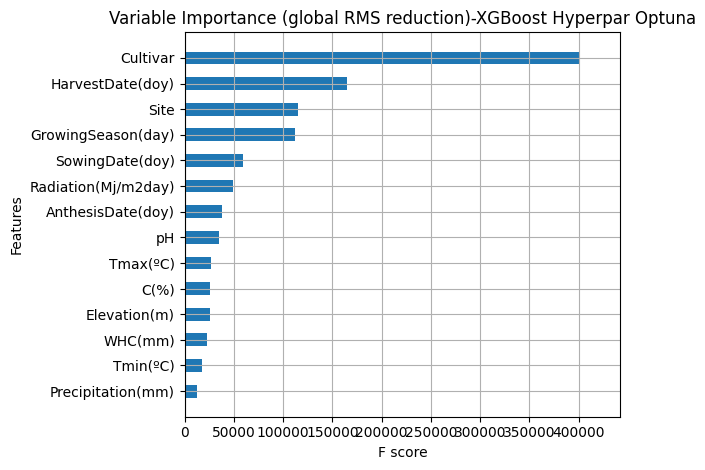

In [14]:
xgb.plot_importance(
    xgb_best,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost Hyperpar Optuna')
plt.tight_layout()
plt.show()

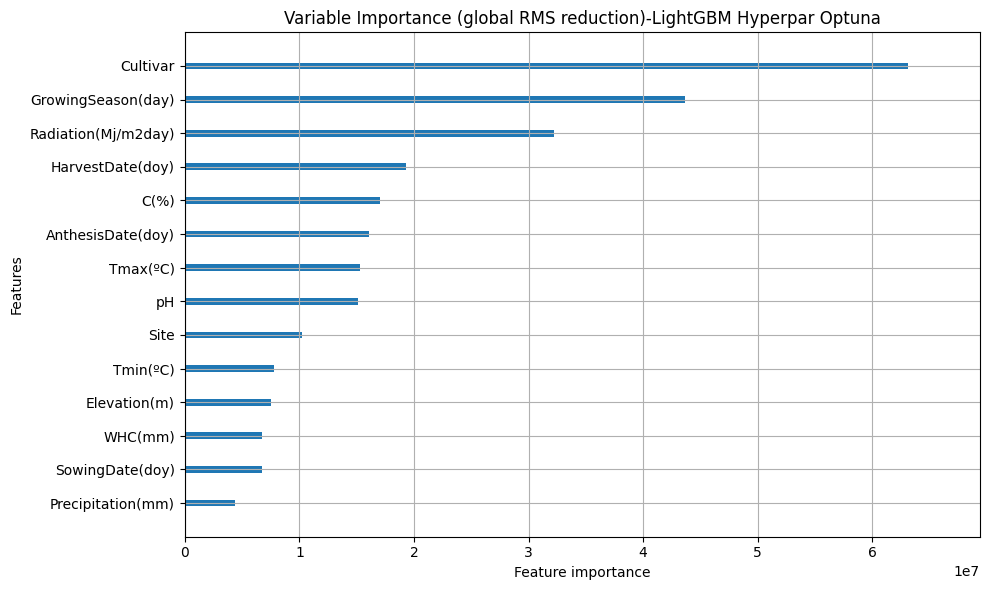

In [15]:
booster = lgb_best.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title('Variable Importance (global RMS reduction)-LightGBM Hyperpar Optuna')
plt.tight_layout()
plt.show()

### Variable permutation  Tests

📊 Test de Permutación - LightGBM Optuna


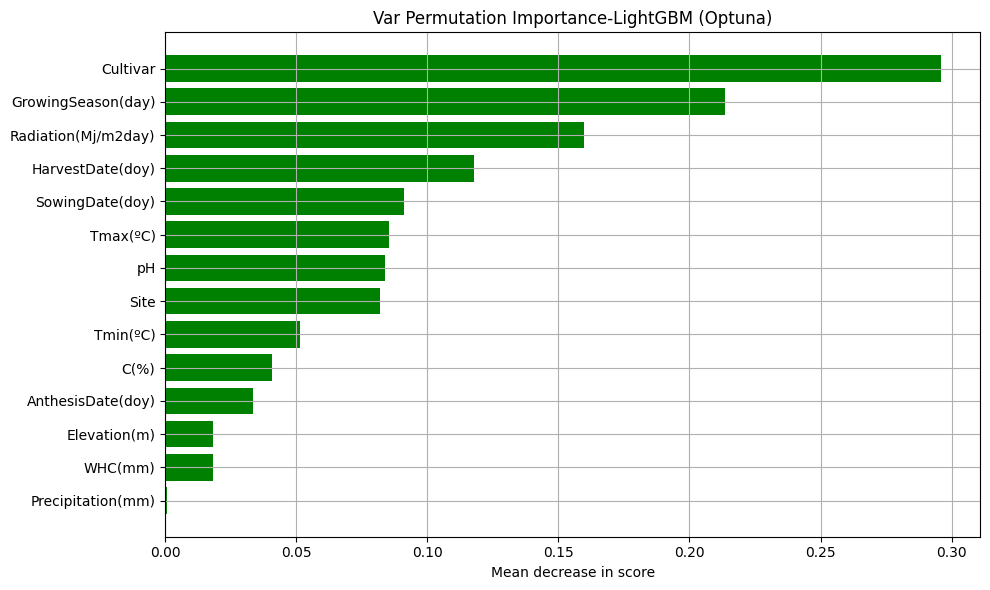

Var Permutation Importance-XGBoost (Optuna)


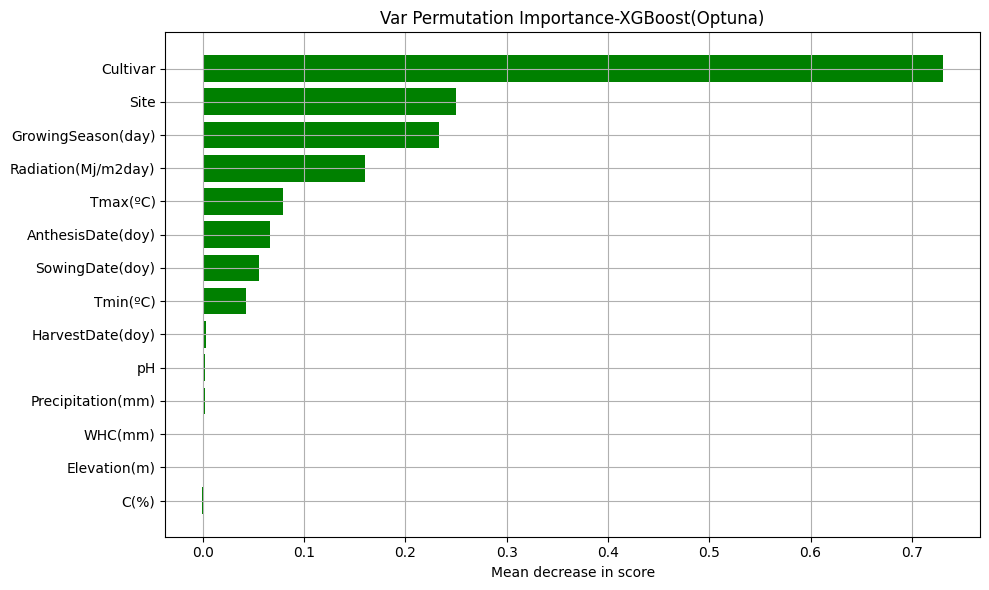

In [16]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Test de permutación para LightGBM optimizado
print("📊 Test de Permutación - LightGBM Optuna")
perm_lgb = permutation_importance(
    lgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_lgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_lgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-LightGBM (Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Test de permutación para XGBoost optimizado
print("Var Permutation Importance-XGBoost (Optuna)")
perm_xgb = permutation_importance(
    xgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_xgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_xgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-XGBoost(Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()


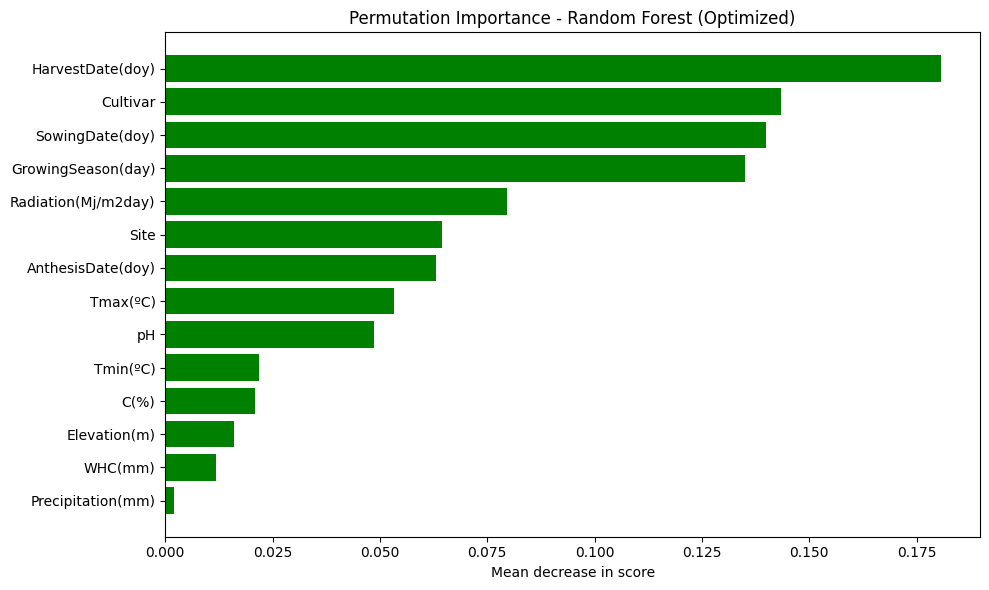

In [17]:

# 📊 Permutation importance - Random Forest (optimized)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

perm_rf = permutation_importance(rf_best, X_test_enc, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf = perm_rf.importances_mean

# Agrupar por variable base (si es one-hot)
def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df['grupo'] = importance_df['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
    return importance_df.groupby('grupo', as_index=False)['importance'].sum().sort_values(by='importance', ascending=True)

feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f"Feature_{i}" for i in range(X_train_enc.shape[1])]
df_rf_perm = agrupar_importancias(importances_rf, feature_names)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_rf_perm['grupo'], df_rf_perm['importance'],color='green')
plt.title("Permutation Importance - Random Forest (Optimized)")
plt.xlabel("Mean decrease in score")
plt.tight_layout()
plt.show()


### SHAP Values

📌 SHAP Values for Optimized LightGBM



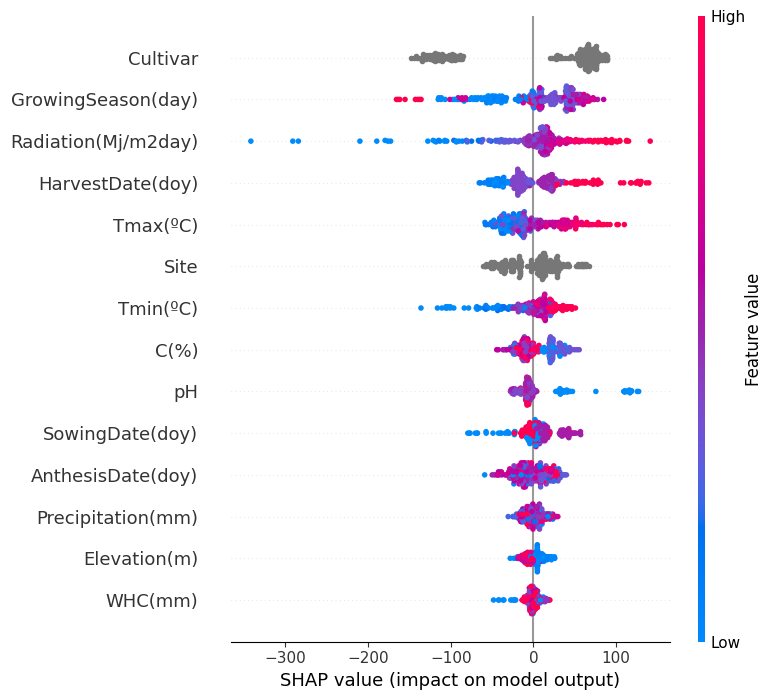

In [18]:
# 🔍 Calcular y visualizar SHAP values para LightGBM
import shap
shap.initjs()

# TreeExplainer para modelos basados en árboles como LightGBM
explainer_lgb = shap.TreeExplainer(lgb_best)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Gráfico resumen
shap.summary_plot(shap_values_lgb, X_test)

📌 SHAP for Optmized XGBoost

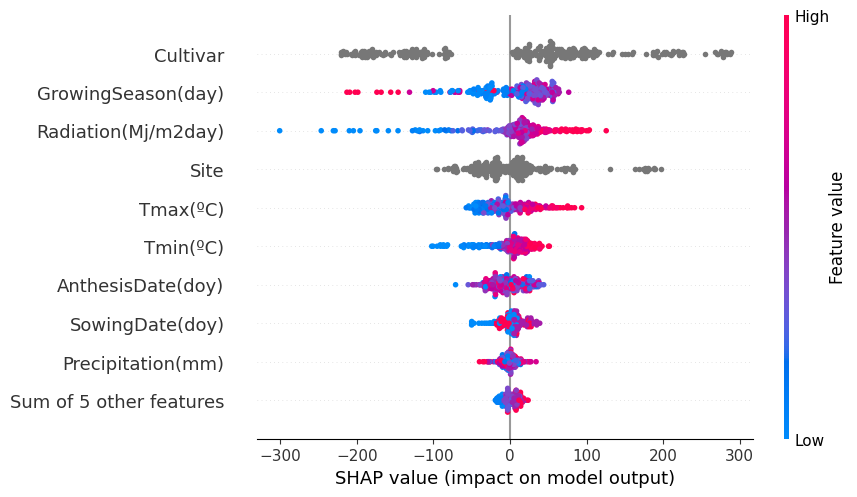

In [19]:
# 🔍 Calcular y visualizar SHAP values para XGBoost
explainer_xgb = shap.TreeExplainer(xgb_best)
shap_values_xgb = explainer_xgb(X_test)

# Gráfico resumen SHAP
shap.plots.beeswarm(shap_values_xgb)

###  💾 SAVING OPTIMIZED MODELS

In [20]:
import joblib

joblib.dump(lgb_best, "lgb_best_model.pkl")
joblib.dump(xgb_best, "xgb_best_model.pkl")
joblib.dump(rf_best, "rfr_best_model.pkl")

print("Succesfully exported models.")


Succesfully exported models.


In [21]:
try:
  lgb_best.booster_.save_model("CP_lgb_best_model.txt")
except Exception as e:
    print("❌ Error saving the model LightGBM:", e)

## PREDICTION

In [22]:
# 📦 Cargar modelos y realizar predicciones con nuevos datos
import joblib
try:
    lgb_loaded = joblib.load("lgb_best_model.pkl")
except Exception as e:
    print("❌ Error al cargar el modelo LightGBM:", e)
lgbm_loaded = joblib.load("lgb_best_model.pkl")
xgb_loaded = joblib.load("xgb_best_model.pkl")
rfr_loaded = joblib.load("rfr_best_model.pkl")

columnas = ['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)','Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)','GrowingSeason(day)']

datos = [['Barcia','A200',25,21,56.6,20.5,16.7,90,1.8999999999999997,5.200000000000003,133,228.70531400966183,250,117]]

print(len(columnas))
print(len(datos))

# Crear DataFrame
X_nuevos_datos = pd.DataFrame(datos, columns=columnas)
X_nuevos_datos["Site"] = X_nuevos_datos["Site"].astype("category")
X_nuevos_datos["Cultivar"] = X_nuevos_datos["Cultivar"].astype("category")

# Reemplazar X_nuevos_datos por datos reales
y_pred_lgb = lgb_loaded.predict(X_nuevos_datos)
y_pred_xgb = xgb_loaded.predict(X_nuevos_datos)
print(y_pred_lgb)
print(y_pred_xgb)

14
1
[1023.05872886]
[1105.7931]
